# Create a Multi-source datamodule for Maptiles
- Jan 6, 2021
- Jan 22, 2021

## Load libraries

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os,sys
import re
import math
from datetime import datetime
import time
sys.dont_write_bytecode = True

In [4]:
import pandas as pd

import numpy as np
import joblib
import matplotlib.pyplot as plt

from pathlib import Path
from typing import Any, List, Set, Dict, Tuple, Optional, Iterable, Mapping, Union, Callable, TypeVar

from pprint import pprint
from ipdb import set_trace as brpt

In [5]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from  torch.linalg import norm as tnorm
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import datasets, transforms

import pytorch_lightning as pl
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.tuner.tuning import Tuner


# Select Visible GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

## Set Path 
1. Add project root and src folders to `sys.path`
2. Set DATA_ROOT to `maptile_v2` folder

In [6]:
this_nb_path = Path(os.getcwd())
ROOT = this_nb_path.parent
SRC = ROOT/'src'
DATA_ROOT = Path("/data/hayley-old/maptiles_v2/")
paths2add = [this_nb_path, ROOT]

print("Project root: ", str(ROOT))
print('Src folder: ', str(SRC))
print("This nb path: ", str(this_nb_path))


for p in paths2add:
    if str(p) not in sys.path:
        sys.path.insert(0, str(p))
        print(f"\n{str(p)} added to the path.")
# print(sys.path)

Project root:  /data/hayley-old/Tenanbaum2000
Src folder:  /data/hayley-old/Tenanbaum2000/src
This nb path:  /data/hayley-old/Tenanbaum2000/nbs

/data/hayley-old/Tenanbaum2000 added to the path.


In [7]:
from src.data.datamodules.maptiles_datamodule import MaptilesDataModule

from src.data.transforms.transforms import Identity, Unnormalizer, LinearRescaler, Monochromizer
from src.data.transforms.functional import unnormalize, to_monochrome

from src.visualize.utils import show_timg, show_timgs, show_batch, make_grid_from_tensors
from src.utils.misc import info
from collections import OrderedDict, defaultdict
from PIL import Image

## Maptiles Dataset
- possible to hold multiple styles

In [8]:
from src.data.datasets.maptiles_bifactor import MaptilesDataset

In [9]:
# Instantiate dataset
data_root = Path("/data/hayley-old/maptiles_v2/")
cities = ['paris']
styles = ['OSMDefault', 'CartoVoyagerNoLabels']
zooms = ['14']
ds = MaptilesDataset(
    data_root=data_root,
    cities=cities,
    styles=styles,
    zooms=zooms,
)

Unique styles:  ['CartoVoyagerNoLabels' 'OSMDefault']
7667712.0
> /data/hayley-old/Tenanbaum2000/src/data/datasets/maptiles_bifactor.py(275)get_channelwise_mean_std()
    274         breakpoint()
--> 275         channel_mean = channel_sum / n_pixels
    276         channel_std = np.sqrt(channel_squared_sum / n_pixels - channel_mean ** 2)



ipdb>  c


117
shape:  (256, 256, 3)
dtype:  float32
min, max:  0.08627451 0.99607843


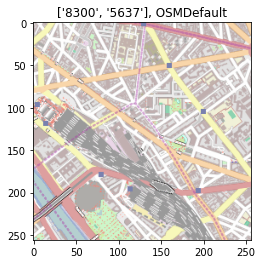

shape:  (256, 256, 3)
dtype:  float32
min, max:  0.7372549 1.0


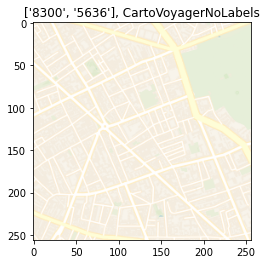

shape:  (256, 256, 3)
dtype:  float32
min, max:  0.20784314 1.0


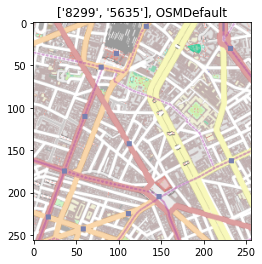

shape:  (256, 256, 3)
dtype:  float32
min, max:  0.37254903 1.0


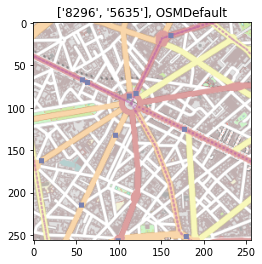

shape:  (256, 256, 3)
dtype:  float32
min, max:  0.17254902 1.0


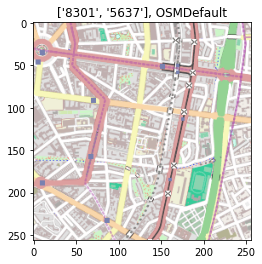

shape:  (256, 256, 3)
dtype:  float32
min, max:  0.7019608 1.0


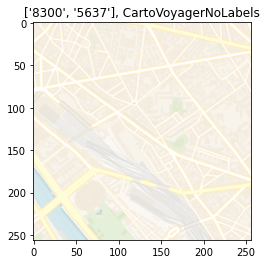

shape:  (256, 256, 3)
dtype:  float32
min, max:  0.21176471 1.0


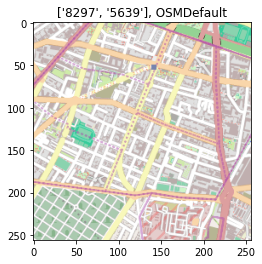

shape:  (256, 256, 3)
dtype:  float32
min, max:  0.18039216 0.99607843


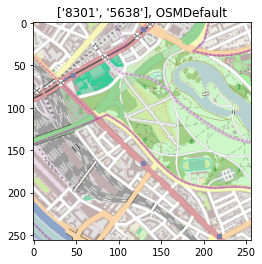

shape:  (256, 256, 3)
dtype:  float32
min, max:  0.60784316 1.0


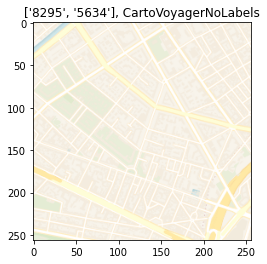

shape:  (256, 256, 3)
dtype:  float32
min, max:  0.16078432 0.99607843


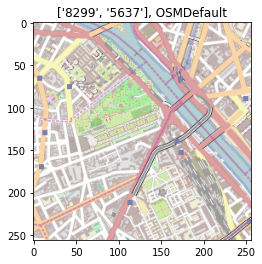

In [15]:
print(len(ds))

n_samples = 10
for i in range(n_samples):
    idx = np.random.choice(len(ds))
    sample = ds[idx]
    x, label_c, label_s = ds.unpack(sample)
    info(x)
    plt.imshow(x)
    plt.title(f"{label_c}, {label_s}")
    plt.show()


## Maptiles DataModule

In [20]:
from src.data.datamodules.multisource_maptiles_datamodule import MultiMaptilesDataModule

In [38]:
# Instantiate data module
data_root = Path("/data/hayley-old/maptiles_v2/")
cities = ['berlin', 'rome'] #['paris']
styles = ['OSMDefault', 'CartoVoyagerNoLabels']#'StamenWatercolor']#, 'StamenTonerLines']
zooms = ['14']
in_shape = (3,128,128)
batch_size = 32

dm = MultiMaptilesDataModule(
    data_root=data_root,
    cities=cities,
    styles=styles,
    zooms=zooms,
    in_shape=in_shape,
    batch_size=batch_size,
)
dm.setup('fit')

Unique styles:  ['CartoVoyagerNoLabels' 'OSMDefault']
Unique styles:  ['OSMDefault' 'CartoVoyagerNoLabels']
Unique styles:  ['OSMDefault' 'CartoVoyagerNoLabels']
n_train, n_val:  1771 758
train channelwise_mean,std:  [0.90276674 0.91129869 0.84952286] [0.11152377 0.0774475  0.12396761]


shape:  torch.Size([32, 3, 128, 128])
dtype:  torch.float32
min, max:  -6.918345 1.2138422


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[['8815', '8749', '8811', '8748', '8789', '8808', '8765', '8797', '8761', '8817', '8816', '8762', '8795', '8806', '8811', '8810', '8794', '8801', '8762', '8799', '8750', '8790', '8791', '8796', '8758', '8759', '8809', '8802', '8811', '8769', '8792', '8809'], ['5368', '6093', '5383', '6095', '5367', '5376', '6096', '5377', '6088', '5383', '5378', '6098', '5373', '5373', '5364', '5385', '5368', '5365', '6102', '5376', '6088', '5364', '5371', '5368', '6086', '6097', '5384', '5380', '5370', '6095', '5385', '5368']]
tensor([1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 1, 1, 0, 0, 0, 0, 1])


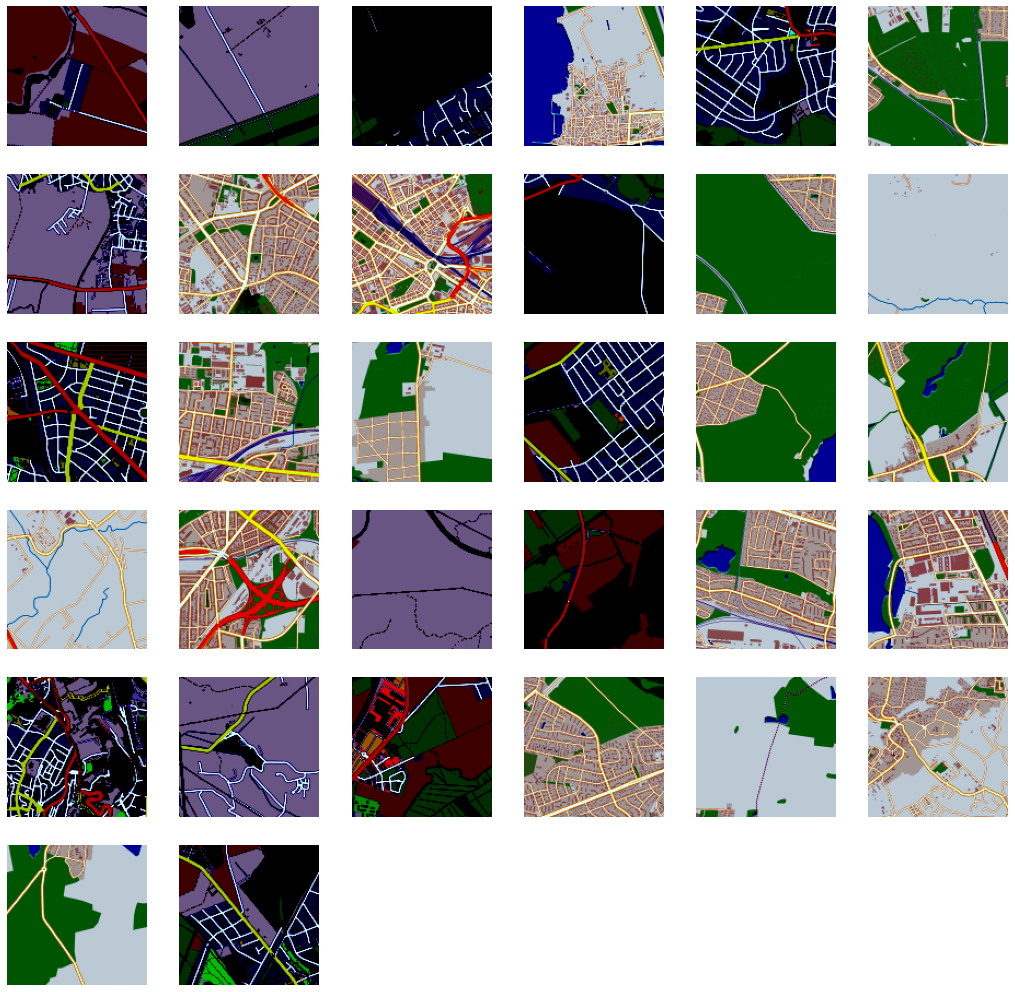

In [39]:
dl = dm.train_dataloader()
batch = next(iter(dl))
x, label_c, label_s = dm.unpack(batch)
info(x)
show_timgs(x)
print(label_c)
print(label_s)

### Concatenate MNIST-M and USPS datasets

- MNISTM
    - original size of an image: (1, 16,16)
    - labels: {0, ..., 9}
- USPS
    - original size of an image: (3, 28, 28)
    - labels" {0, ..., 9}
    

In [ ]:
from src.data.datasets.mnistm import MNISTM
from torchvision.datasets import USPS


In [ ]:
# MNISTM Dataset
bs = 16
num_workers = 16
pin_memory = True
in_shape = (3, 32,32)
xforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(in_shape[-2:]),
    ])
# target_xforms = transforms.Lambda(lambda y: torch.tensor(y)) # already-so
mnistm_ds = MNISTM(ROOT/'data', 
          transform=xforms,
          download=True)

mnistm_dl = DataLoader(mnistm_ds, batch_size=bs, shuffle=True, 
               num_workers=num_workers, pin_memory=pin_memory)


x,y = next(iter(mnistm_dl))
info(x)
info(y)
# show_timgs(x)

In [ ]:
# USPS Dataset
bs = 16
num_workers = 16
pin_memory = True
n_channels = 3
in_shape = (n_channels, 32,32)
xforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(in_shape[-2:]),
    transforms.Lambda(lambda x: x.repeat((n_channels, 1, 1)))
    ])
target_xforms = transforms.Lambda(lambda y: torch.tensor(y))
usps_ds = USPS(ROOT/'data', 
          transform=xforms,
          target_transform=target_xforms,
          download=True)

usps_dl = DataLoader(usps_ds, batch_size=bs, shuffle=True, 
               num_workers=num_workers, pin_memory=pin_memory)


x,y = next(iter(usps_dl))
info(x)
info(y)
# show_timgs(x, cmap='gray')

In [ ]:
# Concatenated dataset
ds = ConcatDataset([mnistm_ds, usps_ds])

# DataLoader w/o shuffling will iterate over the datasets in order 
# -- So, iterate over mnistm_ds and then iterate over usps_ds
ordered_dl = DataLoader(ds, batch_size=16, shuffle=False)
x, y = next(iter(ordered_dl))
show_timgs(x)
info(x)
info(y)

In [ ]:
# DataLoader w/ shuffling will iterate over the concatenated dataset
# in random order
# -- So, iterate over a mixed images from mnistm_ds and usps_ds
shuffled_dl = DataLoader(ds, batch_size=32, shuffle=True)
x, y = next(iter(shuffled_dl))
show_timgs(x)
info(x)
info(y)

In [ ]:
len(mnistm_ds), len(usps_ds)

Notice however, MNIST-M dataset has a lot more samples (60,000 vs. 7291). 
A quick fix to create a single dataloader (from multi dataset sources) so that each mini-batch of sample to have equal/balanced number of samples from each dataset, is to... pass in that many copies of the smaller-sized dataset:

- see: https://discuss.pytorch.org/t/train-simultaneously-on-two-datasets/649/36

In [ ]:
# Balanced Concatenated dataset
n_copies = len(mnistm_ds)//len(usps_ds)
dsets = [mnistm_ds]
dsets.extend([usps_ds for i in range(n_copies)])

balanced_ds = ConcatDataset(dsets)

# DataLoader w/o shuffling will iterate over the datasets in order 
# -- So, iterate over mnistm_ds and then iterate over usps_ds
ordered_dl = DataLoader(balanced_ds, batch_size=16, shuffle=False)
x, y = next(iter(ordered_dl))
show_timgs(x)
info(x)
info(y)

In [ ]:
# DataLoader w/ shuffling will iterate over the concatenated dataset
# in random order
# -- So, iterate over a mixed images from mnistm_ds and usps_ds
shuffled_dl = DataLoader(balanced_ds, batch_size=32, shuffle=True)
x, y = next(iter(shuffled_dl))
show_timgs(x)
info(x)
info(y)